In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from auto_ts import auto_timeseries
from pmdarima.arima import auto_arima,ADFTest
from autots import AutoTS

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings


Imported auto_timeseries version:0.0.92. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



## On va essayer de construire un modèle pour chaque famille produit dans ce notebook 

In [2]:
def r2_ajuste(r2,n,p):

    return  1 - (  ((1 - r2) * (n - 1)) / (n - p - 1)  )

def determine_petit_truc(series):
    min_positive_value = series[series > 0].min()
    val = 0.00001
    return min_positive_value * val

# Fonction pour tester la stationnarité avec le test ADF
def test_stationarity(series):
    result = adfuller(series.dropna())
    return result[1]  # Retourne la p-value

# Fonction pour appliquer la transformation logarithmique
def apply_log(series, p):
    return np.log(series + p)

## reconstruction pour un dataframe 
def deDiff(orig, diff,order,log_order):
    dfout = pd.DataFrame(index=orig.index, columns=orig.columns)
    cols = orig.columns

    for family in cols:
        #affectation des premières valeurs 
        dfout[family].iloc[:order] = orig[family].iloc[:order]
        # recontruction du reste
        for i in range(order, len(orig)):
            dfout[family].iloc[i] = dfout[family].iloc[i-order]  +  diff[family].iloc[i-order]
        dfout[family]
        if log_order == 1:
            dfout = np.exp(dfout)
    return dfout
## reconstruction pour une colonne de dataframe 

def f(orig, diff, order,log_order):
    """
    Fonction poure reconstruire les colonnes de dataframes à différenciation
    orig = la colonne originale
    diff = la colonne des valuers différenciées
    order = l'ordre de différentiation de la colone
    log_order = 1 si on a utilisé un logarithme et 0 sinon
    """
    dfout = pd.Series(index=orig.index, dtype=orig.dtype)
    dfout.iloc[:order] = orig.iloc[:order]
    for i in range(order, len(orig)):
        dfout.iloc[i] = dfout.iloc[i-order] + diff.iloc[i-order]
    if log_order == 1:
        dfout = np.exp(dfout)
    return dfout

## Chargement des données 

In [3]:
dfOrig = pd.read_csv("D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\Processed\\Product families over time.csv")
dfOrig = dfOrig.set_index('Product Family').T

In [4]:
# Charger les données des séries différenciées à partir d'un fichier CSV
df_differentiated = pd.read_csv('D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\For_Modeling\\series_differenciees.csv')
df_transfo = pd.read_csv('D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\For_Modeling\\transformations_appliquees.csv')
df_transfo.set_index('family', inplace=True)

## Auto arima pour trouver le meilleur modèle 

In [5]:
# Ignorer les avertissements liés à l'auto-ARIMA pour garder le code propre
warnings.filterwarnings("ignore")

best_models = {}
      #  transfo_family = dictTransformations.loc[family]
      #  diff_order = transfo_family['ordreP']  
# Parcourir chaque colonne (chaque série temporelle)
"""
df_train = df_diff.iloc[:-n]
df_test = df_diff.iloc[-n:]
"""
n = 3
for col in df_differentiated.columns:
    print(f"Processing series: {col}")

    #series = df_differentiated[col].dropna()  # Supprimer les éventuels NaN
    if col == "Unnamed: 0" : 
        continue
    else : 
        train = dfOrig[col].iloc[:-n]
        test = dfOrig[col].iloc[-n:]
        #diff_fam = df_transfo.loc[col]
        # Appliquer l'auto-ARIMA pour trouver le meilleur modèle
        model = auto_arima(
            train,
            start_p=1,
            start_q=1,
            max_p=5, 
            max_q=5,
            d = None, #int(diff_fam['ordreP'])
           # seasonal=False,  # Modèle non saisonnier
            error_action='warn',
            stepwise=True,  # Méthode plus rapide en recherchant de manière itérative
            trace=True,  # Afficher le processus de sélection du modèle
            test = "adf"
        )
    best_models[col] = model

# Affichage des modèles trouvés
for col, model in best_models.items():
    print(f"\nBest model for {col}:")
    print(model.summary())


Processing series: Unnamed: 0
Processing series: A
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1302.470, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1335.461, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1308.780, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1309.929, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1333.556, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1303.551, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1305.276, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1305.041, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1303.157, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1306.305, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1301.686, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1306.004, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1307.309, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1303.0

## Affichage du meilleur modèle pour chaque famille

In [6]:
# Exemple de données (à remplacer par les données réelles)
data = {
    "Série Temporelle": list(best_models.keys()),
    "Modèle ARIMA": [f"ARIMA{model.order}" for model in best_models.values()],
    "AIC": [model.aic() for model in best_models.values()],
    "BIC": [model.bic() for model in best_models.values()],
}

# Créer un DataFrame
df_summary = pd.DataFrame(data)

# Afficher le DataFrame
#print(df_summary)

# displaying the DataFrame
df_summary.style.set_properties(**{"border": "1.5px solid #ffffff", "color": "red", 'background-color': '#ccffff'}) # 'background-color': '#ffffb3'

,Série Temporelle,Modèle ARIMA,AIC,BIC
0,A,"ARIMA(1, 1, 1)",1301.685680,1307.361141
1,B,"ARIMA(0, 0, 0)",1314.659372,1318.483418
2,C,"ARIMA(1, 1, 1)",1262.396301,1268.071762
3,D,"ARIMA(0, 0, 1)",1341.508711,1347.244780
4,E,"ARIMA(0, 0, 1)",1439.435262,1445.171331
5,F,"ARIMA(2, 1, 1)",1491.762343,1499.329624
6,G,"ARIMA(3, 1, 2)",1201.096218,1214.338960
7,H,"ARIMA(0, 0, 0)",1180.736937,1184.560983
8,I,"ARIMA(0, 0, 0)",969.375275,973.199321
9,J,"ARIMA(0, 1, 1)",1337.781448,1341.565089


## Calcul des métriques pour le baseline model

#### SMAPE : Symetric Mean Absolute Percentage Error
#### Adjusted SMAPE : Adjusted Symmetric Mean Absolute Percentage Error
#### MAPE : Mean Absolute Percentage Error
#### MAAPE : Mean Arctangent Absolute Percentage Error

In [16]:
# Fonction pour calculer SMAPE
def smape(y_true, y_pred):
    smape_val = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return smape_val

# Fonction pour calculer l'Adjusted SMAPE (ASMAPE)
def adjusted_smape(y_true, y_pred):
    adjsmape = 1/y_true.size  * np.sum( np.abs(y_pred - y_true) / ( np.abs(y_true) + np.abs(y_pred) )*100 )
    oldadjsmape = 100 * np.mean(np.abs(y_pred - y_true) / (0.5 * (np.abs(y_true) + np.abs(y_pred))))
    return adjsmape
# Fonction pour calculer le MAAPE
def maape(actual, forecast):
    maape = np.mean(np.arctan(np.abs((actual - forecast) / actual))) * (180/np.pi)
    return maape

# Créer un dictionnaire pour stocker les métriques
metrics = {}
n = 3
# Parcourir chaque modèle ajusté
for col, model in best_models.items():
    # Obtenir la série originale (sans NaN)
    #series = df_differentiated[col].dropna()
    
    # Diviser les données
    train = dfOrig[col].iloc[:-n]
    test = dfOrig[col].iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test
    predictions = model.predict(n_periods=n)
    # print(col, model)
    # print("Val réelles","\n", test.dtype)
    # print("Prédictions", "\n",predictions.dtype)
    # Calculer les métriques
    me = np.mean(predictions - test)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    maape_value = maape(test, predictions)
    smape_value = smape(test, predictions)
    asmape_value = adjusted_smape(test, predictions)

    if train is not None:
        naive_forecast = np.roll(train, shift=1)[1:]
        naive_mae = np.mean(np.abs(train[1:] - naive_forecast))
        mase = mae / naive_mae
    else:
        mase = None
    # Enregistrer les métriques
    metrics[col] = {
        "ME":me,
        "RMSE":rmse,
        "MAE":mae, 
        "MASE":mase,
        "MAAPE": maape_value,
        "MAPE": mape,
        "ASMAPE": asmape_value
    }

# Afficher les métriques pour chaque série
for col, metric in metrics.items():
    print(f"\nMetrics for {col}:")
    
    print(f"ME: {metric['ME']}")
    print(f"RMSE: {metric['RMSE']}")
    print(f"MAE: {metric['MAE']}")
    print(f"MASE: {metric['MASE']}")
    
    
    print(f"MAAPE: {metric['MAAPE']}°")
    print(f"MAPE: {metric['MAPE']}%")
    print(f"ASMAPE: {metric['ASMAPE']}%")


Metrics for A:
ME: nan
RMSE: 68809.07072855945
MAE: 50356.57959193174
MASE: 0.3252994436301709
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for B:
ME: nan
RMSE: 163746.92446135776
MAE: 134463.14666666667
MASE: 1.034864113265577
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for C:
ME: nan
RMSE: 87950.68564210324
MAE: 59723.21626785848
MASE: 0.5431801910173483
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for D:
ME: nan
RMSE: 212449.33975794143
MAE: 203457.19040596773
MASE: 1.0218844319737204
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for E:
ME: nan
RMSE: 437397.5468989378
MAE: 351375.58751817845
MASE: 0.6726599385994196
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for F:
ME: nan
RMSE: 780509.9286304995
MAE: 739230.542668976
MASE: 0.7169375594653257
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for G:
ME: nan
RMSE: 31238.41782942402
MAE: 23178.41759040846
MASE: 0.44240875370592175
MAAPE: nan°
MAPE: nan%
ASMAPE: 0.0%

Metrics for H:
ME: nan
RMSE: 57760.284921636165
MAE: 47338.95133333333


In [17]:
metrics

{'A': {'ME': nan,
  'RMSE': 68809.07072855945,
  'MAE': 50356.57959193174,
  'MASE': 0.3252994436301709,
  'MAAPE': nan,
  'MAPE': nan,
  'ASMAPE': 0.0},
 'B': {'ME': nan,
  'RMSE': 163746.92446135776,
  'MAE': 134463.14666666667,
  'MASE': 1.034864113265577,
  'MAAPE': nan,
  'MAPE': nan,
  'ASMAPE': 0.0},
 'C': {'ME': nan,
  'RMSE': 87950.68564210324,
  'MAE': 59723.21626785848,
  'MASE': 0.5431801910173483,
  'MAAPE': nan,
  'MAPE': nan,
  'ASMAPE': 0.0},
 'D': {'ME': nan,
  'RMSE': 212449.33975794143,
  'MAE': 203457.19040596773,
  'MASE': 1.0218844319737204,
  'MAAPE': nan,
  'MAPE': nan,
  'ASMAPE': 0.0},
 'E': {'ME': nan,
  'RMSE': 437397.5468989378,
  'MAE': 351375.58751817845,
  'MASE': 0.6726599385994196,
  'MAAPE': nan,
  'MAPE': nan,
  'ASMAPE': 0.0},
 'F': {'ME': nan,
  'RMSE': 780509.9286304995,
  'MAE': 739230.542668976,
  'MASE': 0.7169375594653257,
  'MAAPE': nan,
  'MAPE': nan,
  'ASMAPE': 0.0},
 'G': {'ME': nan,
  'RMSE': 31238.41782942402,
  'MAE': 23178.41759040846

## Intervalles de confiance 

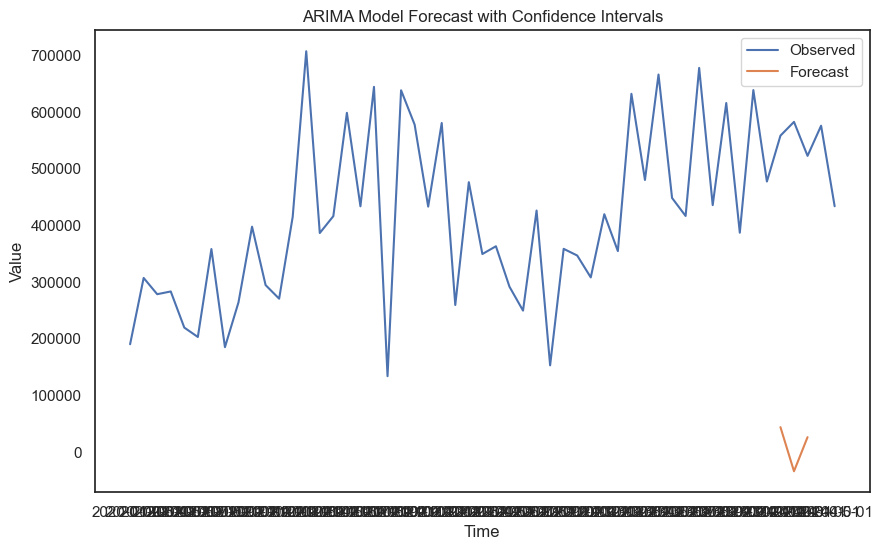

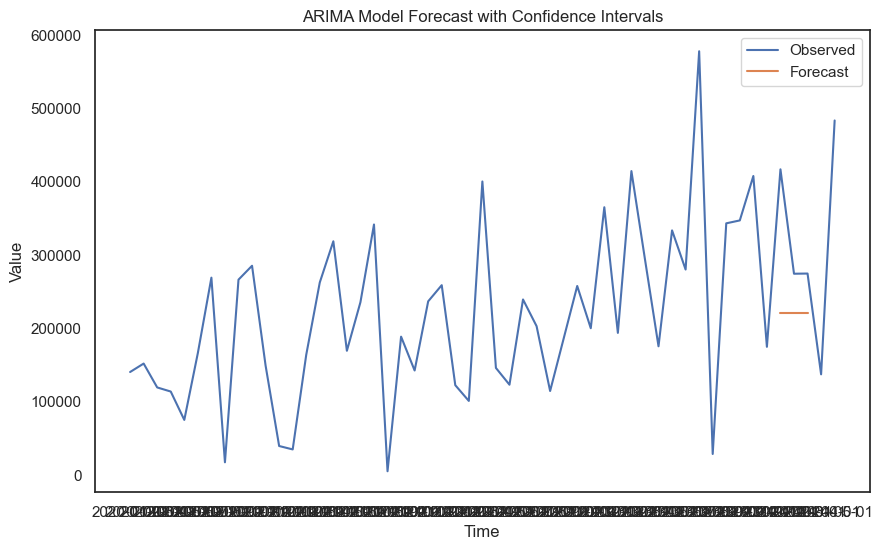

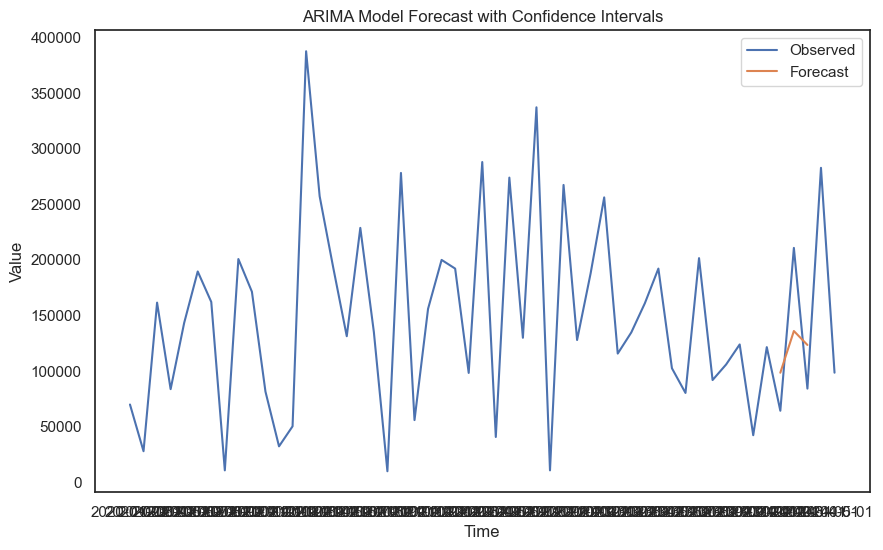

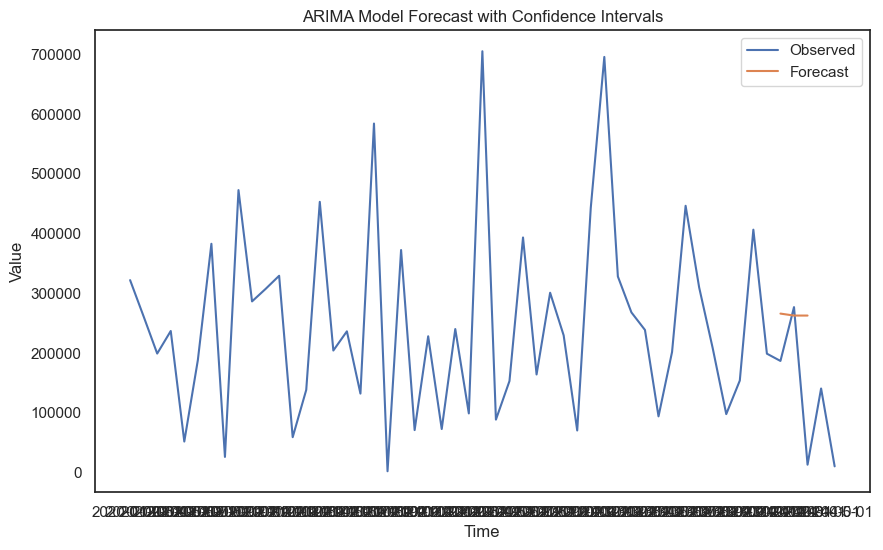

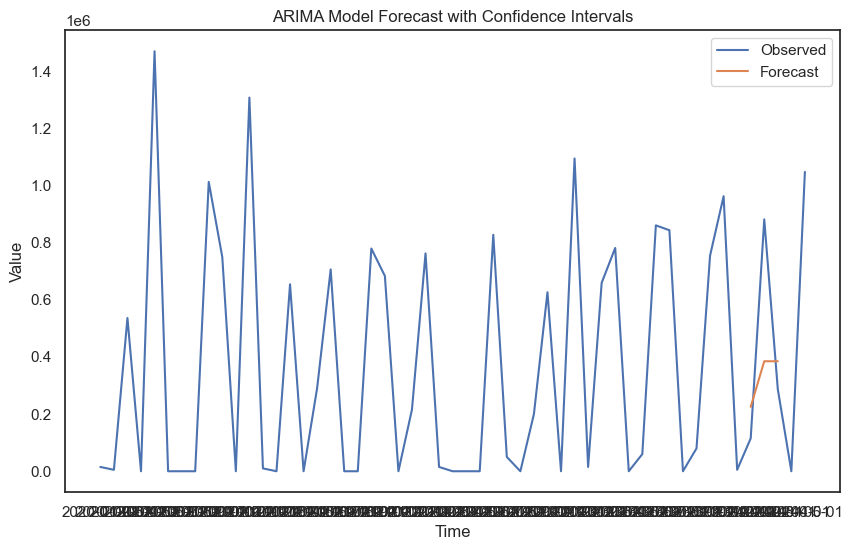

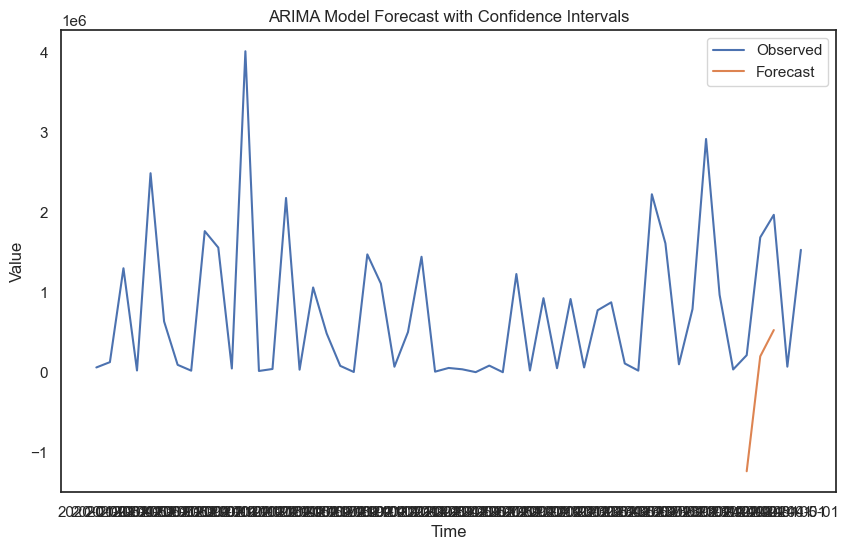

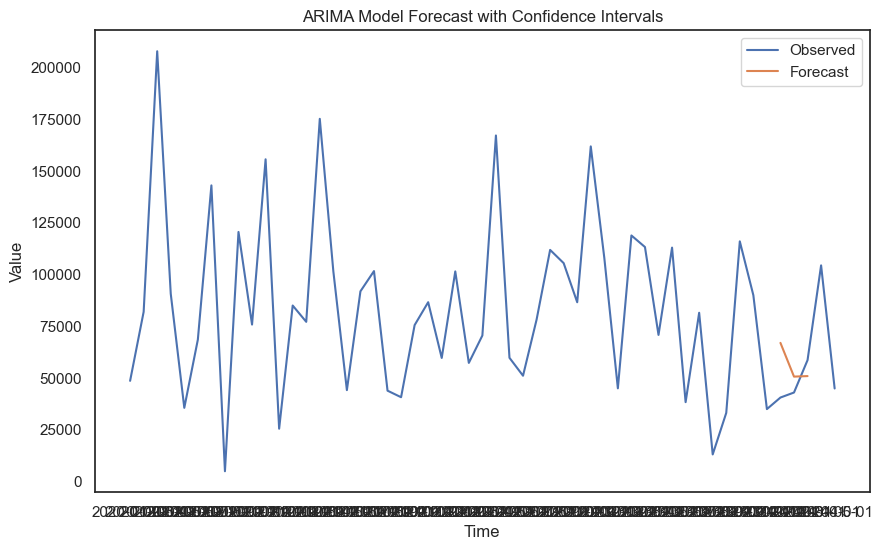

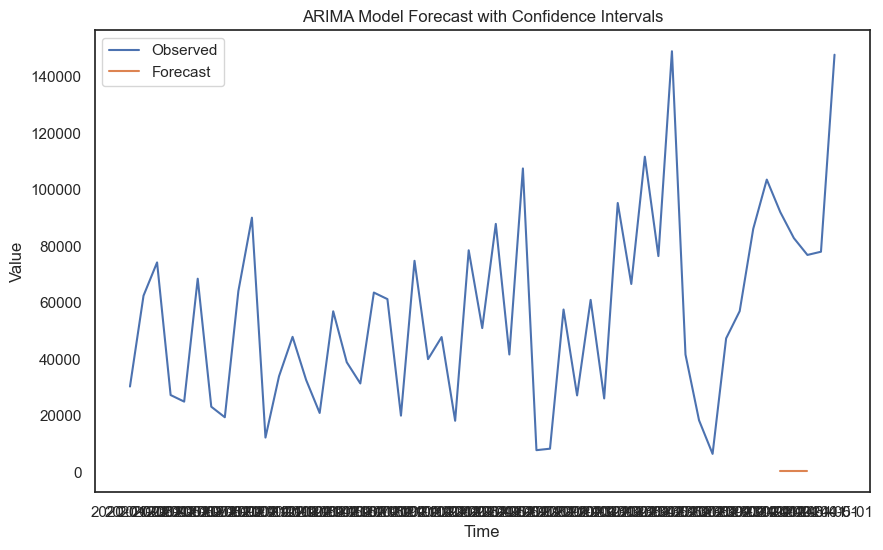

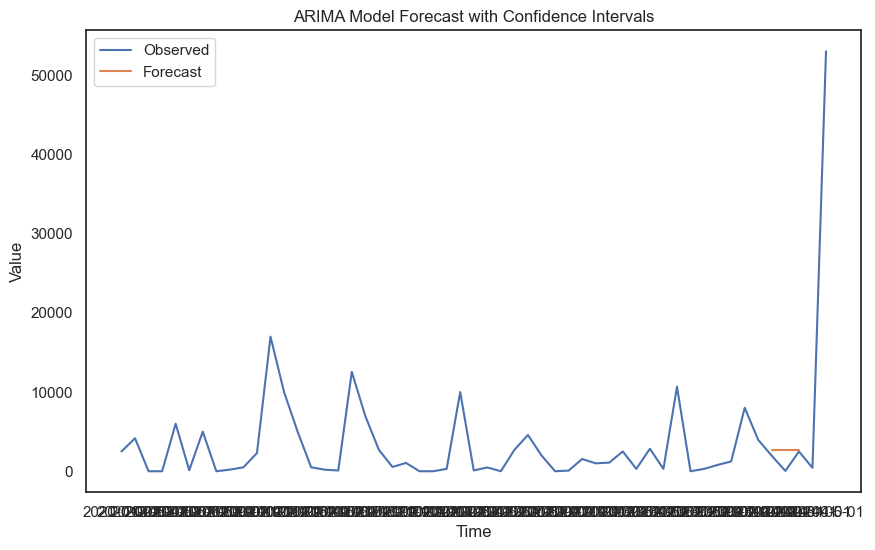

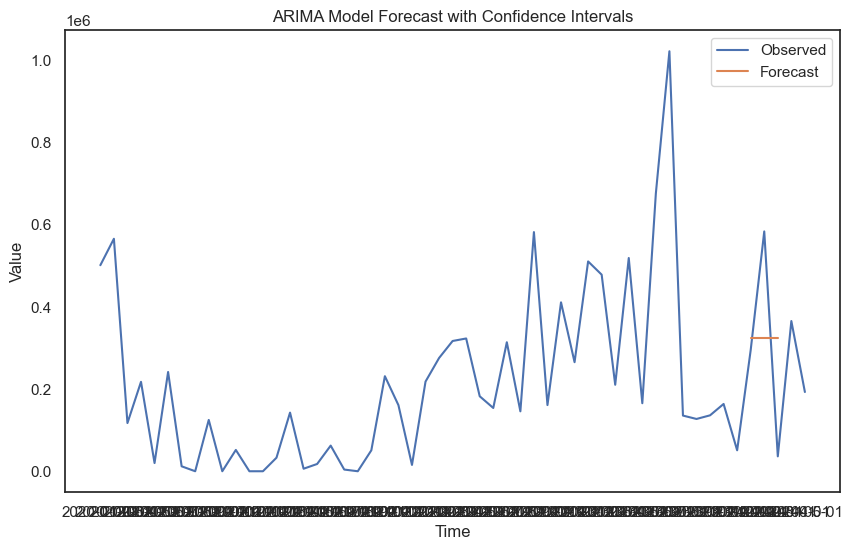

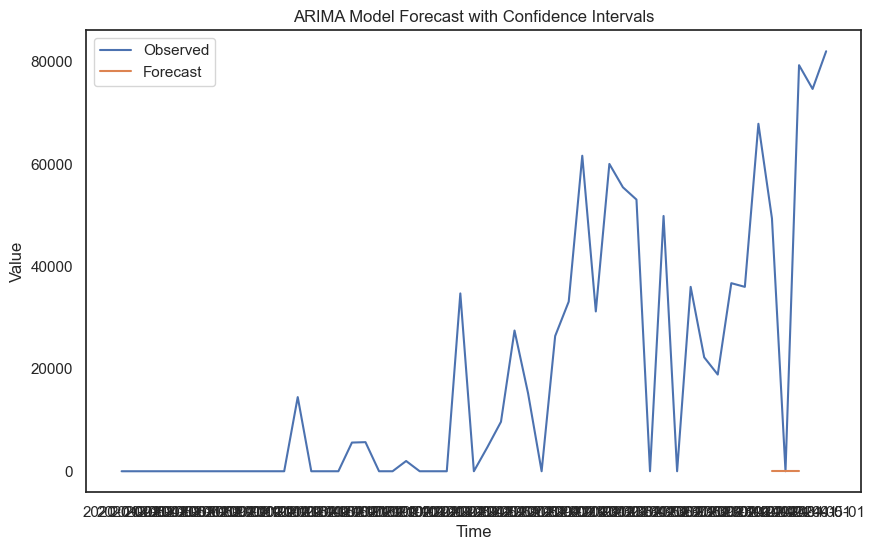

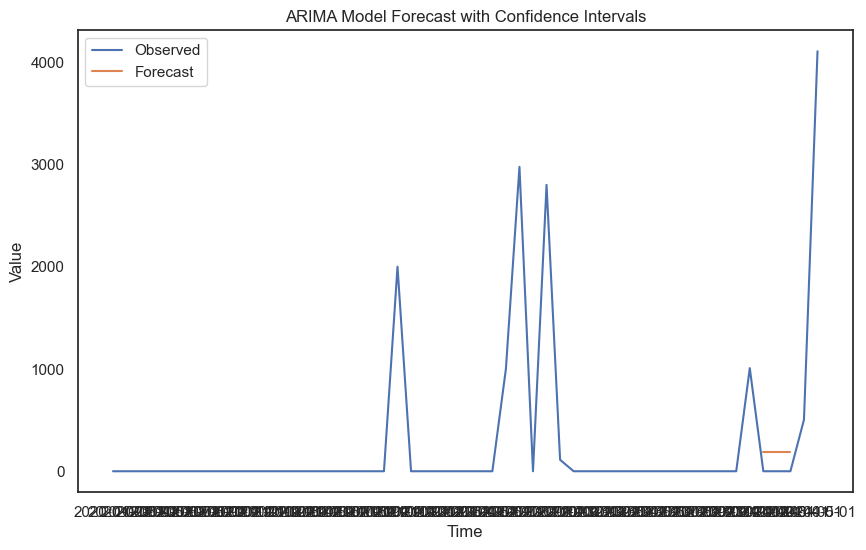

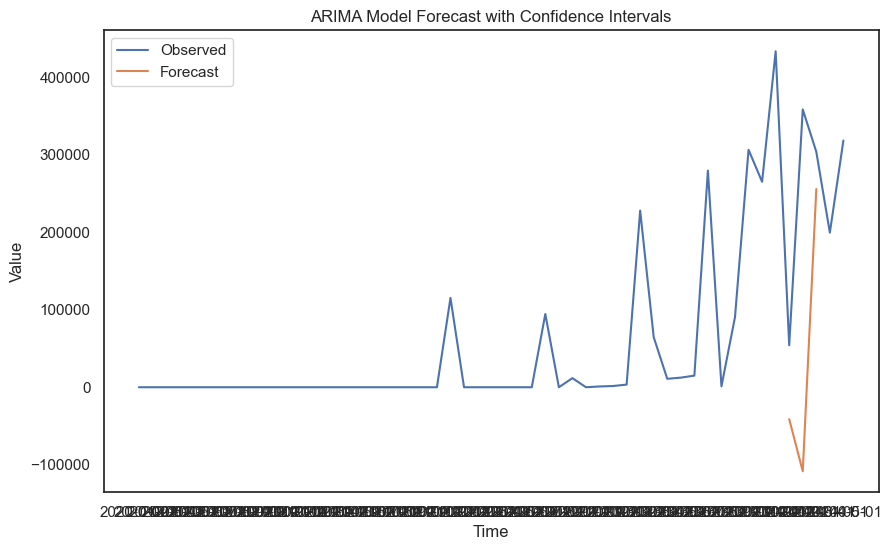

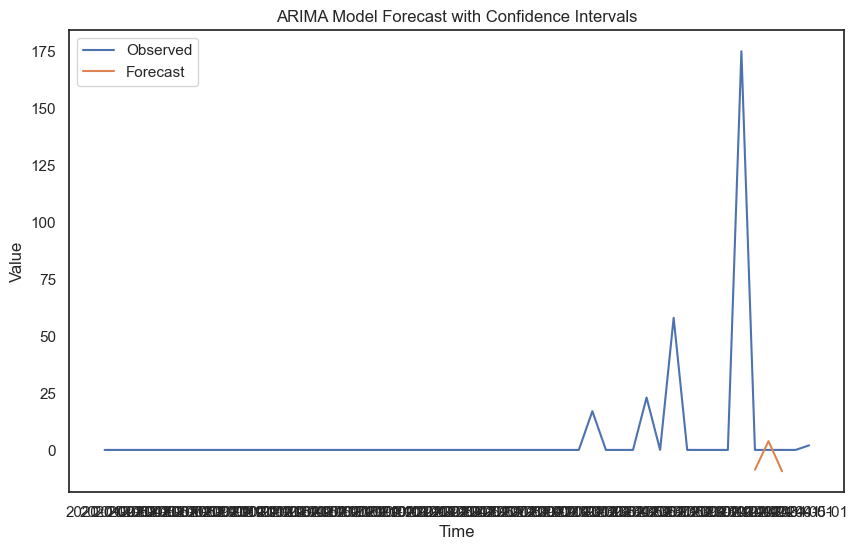

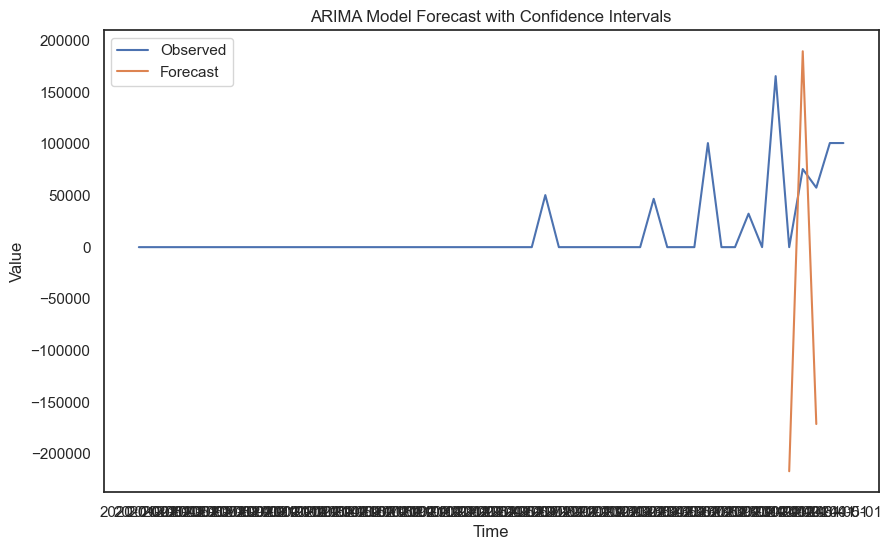

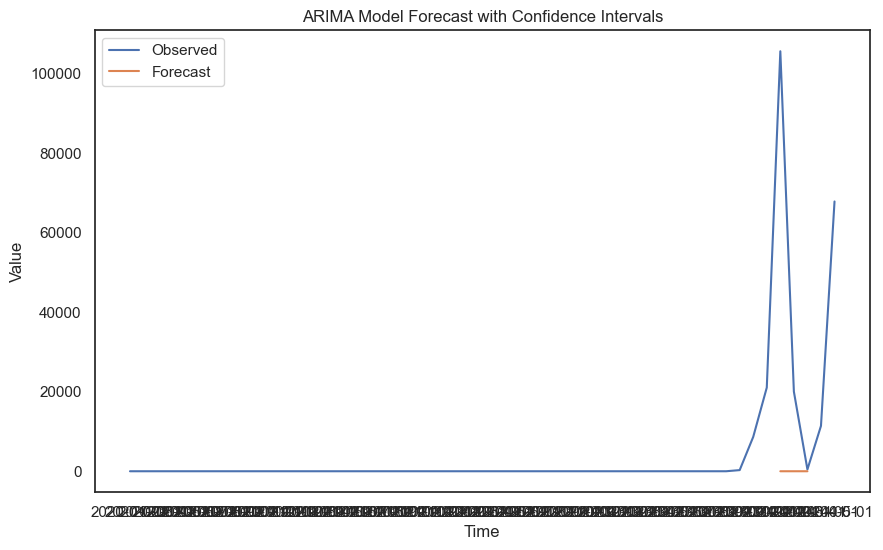

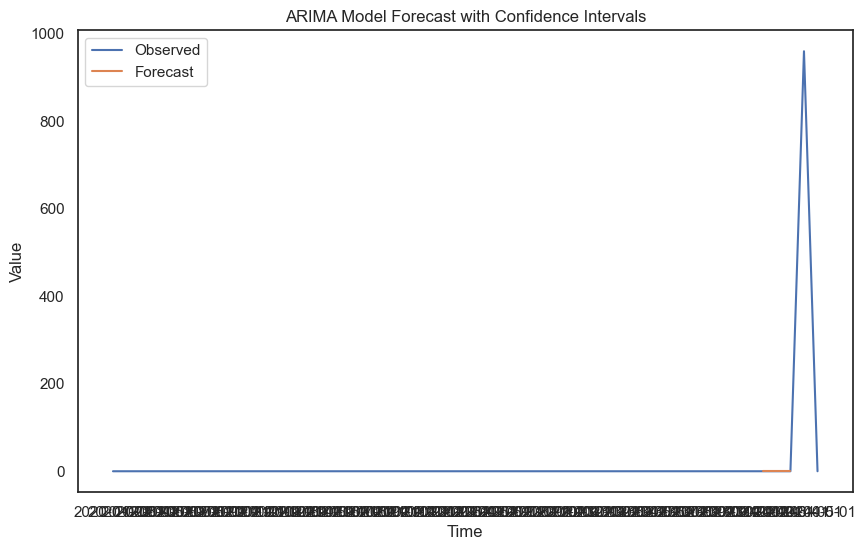

In [8]:
for col, model in best_models.items():
    # Obtenir la série originale (sans NaN)
    data = dfOrig[col]
    series = df_differentiated[col].dropna()
    n = 3
    # Diviser les données
    train = series.iloc[:-n]
    test = series.iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    fittedModel = model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test
    forecast_mean = fittedModel.predict(n_periods=n)
    
    # Si vous avez besoin des intervalles de confiance, vous devrez les calculer ici
    # Supposons que vous calculiez manuellement les intervalles de confiance avec une distribution normale
    confidence_intervals = None
    if hasattr(fittedModel, 'get_forecast'):
        forecast_result = fittedModel.get_forecast(steps=n)
        confidence_intervals = forecast_result.conf_int()

    # Affichage des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label='Observed')
    plt.plot(test.index, forecast_mean, label='Forecast')
    
    if confidence_intervals is not None:
        plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                         color='pink', alpha=0.3, label='Confidence Interval')
    
    plt.title('ARIMA Model Forecast with Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Explication du modèle

In [9]:
#!pip install Explainerdashboard